# Libraries and DATA

In [1]:
from visualizations import *
import numpy as np
import pandas as pd
import warnings
from math import tau
import matplotlib.pyplot as plt
from scipy.integrate import quad
warnings.filterwarnings('ignore')

In [2]:
data = np.loadtxt("./../DATA/digits2k_pixels.data.gz", ndmin=2)/255.0
data.shape = (data.shape[0], int(np.sqrt(data.shape[1])), int(np.sqrt(data.shape[1])))
labels = np.loadtxt("./../DATA/digits2k_pixels.labels.gz", dtype='int')

In [3]:
centroid_distances = np.load('centroid_distances_N_50.npy')

# Needed functions

In [4]:
def determineClusterDigit(labels_true, labels_pred, cluster_num):
    real_labels, counts = np.unique(labels[labels_pred == cluster_num], return_counts=True)
    if len(real_labels) == 0:
        return -1
    return real_labels[np.argmax(counts)]

def assignRealLabels(labels_pred, labels_true):
    label_mapping = dict()
    n_clusters = max(labels_pred)+1
    for i in range(n_clusters):
        label_mapping[i] = determineClusterDigit(labels_true, labels_pred, i)
    
    labels_final_prediction = pd.Series(labels_pred)
    labels_final_prediction = labels_final_prediction.map(label_mapping)
    return labels_final_prediction, label_mapping

In [5]:
# Precision one vs all
def calcPrecision(labels_true, labels_final_prediction):
    digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    precisions = []
    sum_all = 0
    for d in digits:
        all_d = 0
        good_d = 0
        for i in range(len(labels_true)):
            if labels_true[i] == d:
                all_d += 1
                if labels_final_prediction[i] == d:
                    good_d += 1
        precisions.append( (d, good_d/all_d) )
        sum_all += good_d/all_d
    precisions.append( ('average', sum_all/10) )
    return precisions

# Model (Ward)

In [6]:
from sklearn.cluster import AgglomerativeClustering

In [7]:
model = AgglomerativeClustering(n_clusters = 70)
model.fit(centroid_distances)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=70,
                        pooling_func='deprecated')

In [8]:
labels_pred = model.labels_
n_clusters = max(model.labels_)
labels_final_prediction, label_mapping = assignRealLabels(labels_pred, labels)

In [9]:
calcPrecision(labels, labels_final_prediction)

[(0, 0.9057591623036649),
 (1, 0.9545454545454546),
 (2, 0.6666666666666666),
 (3, 0.8952879581151832),
 (4, 0.9205607476635514),
 (5, 0.6666666666666666),
 (6, 0.885),
 (7, 0.7098214285714286),
 (8, 0.6162790697674418),
 (9, 0.7142857142857143),
 ('average', 0.7934872868585773)]

# Model (Affinity Propagation)

In [10]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import precision_score

In [11]:
model = AffinityPropagation()
model.fit(centroid_distances)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)

In [12]:
max(model.labels_)

89

In [13]:
labels_pred = model.labels_
n_clusters = max(model.labels_)
labels_final_prediction, label_mapping = assignRealLabels(labels_pred, labels)

In [14]:
precision_score(y_true = labels, y_pred = labels_final_prediction, average='micro')

0.79

In [15]:
calcPrecision(labels, labels_final_prediction)

[(0, 0.9267015706806283),
 (1, 0.9727272727272728),
 (2, 0.51010101010101),
 (3, 0.837696335078534),
 (4, 0.8925233644859814),
 (5, 0.5444444444444444),
 (6, 0.92),
 (7, 0.7410714285714286),
 (8, 0.6976744186046512),
 (9, 0.8047619047619048),
 ('average', 0.7847701749455855)]

# Predict Custom Number

In [16]:
import numpy as np
from skimage import io
from skimage.transform import resize
from transform_digit import *

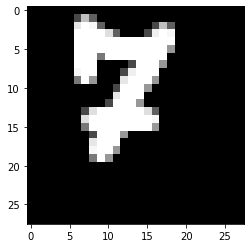

In [17]:
painted = io.imread("./test_new.png", as_grey=True)
plt.imshow(painted, cmap=plt.get_cmap("gray"))

In [18]:
centr_distances_test = transformToDistances(painted)
plt.close()

In [19]:
primal_label = model.predict([centr_distances_test])[0]
primal_label

54

In [20]:
true_label = label_mapping[primal_label]
true_label

7

# Looking Through Clusters

In [21]:
def DisplaySampleOfDigit(digit, nrow=10, ncol=10):
    n = nrow*ncol
    positions_of_digit = np.where(labels_pred == digit)
    positions_of_digit = positions_of_digit[0] # upper function returned a tuple
    # random selection of n positions
    np.random.shuffle(positions_of_digit)
    positions_to_use = positions_of_digit[0:n]
    # setting up image display
    fig, axs = plt.subplots(nrow, ncol, figsize=(20, 20))
    
    for i in range(nrow):
        for j in range(ncol):
            axs[i, j].imshow(data[positions_to_use[i*nrow+j],:,:], cmap=plt.get_cmap("gray"))

IndexError: index 36 is out of bounds for axis 0 with size 36

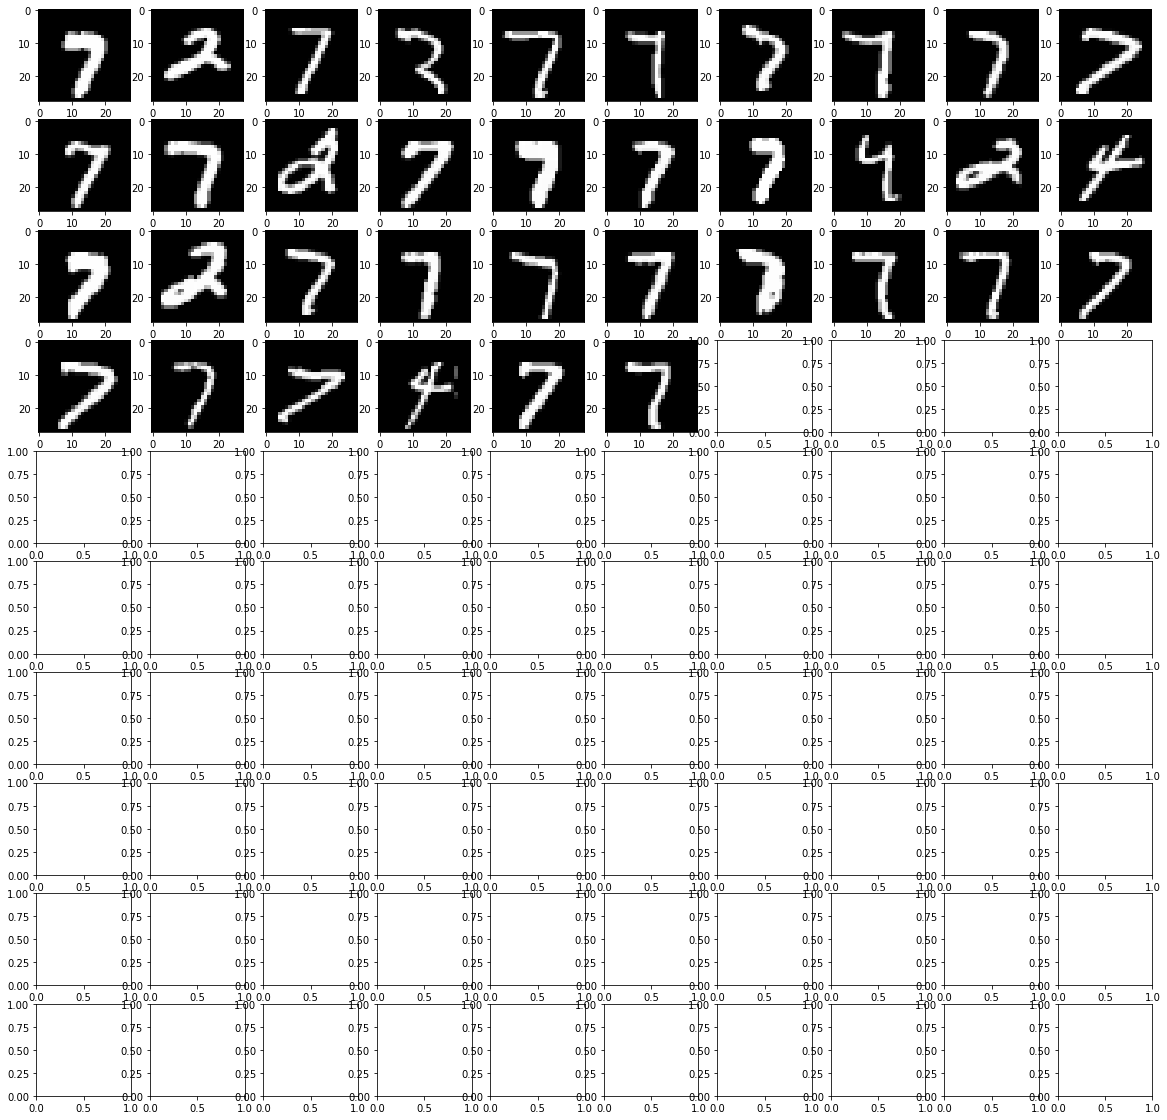

In [22]:
DisplaySampleOfDigit(54)